In [4]:
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
train = pd.read_csv('train_balanced_new.csv')
test = pd.read_csv('vectorized_test.csv')

X_train = train.drop(['label'], axis=1)
y_train = train['label']
X_test = test.drop(['label'], axis=1)
y_test = test['label']

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

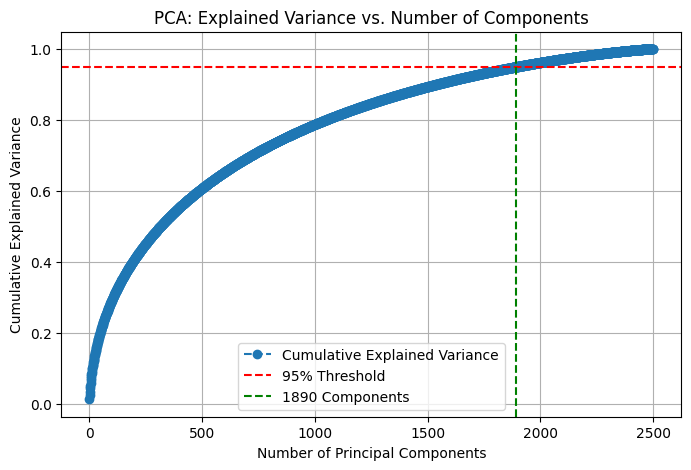

Number of components needed to retain 95% variance: 1890


In [6]:
pca = PCA()
pca.fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', label="Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Threshold")
plt.axvline(x=num_components, color='g', linestyle='--', label=f"{num_components} Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.legend()
plt.grid()
plt.show()
print(f"Number of components needed to retain 95% variance: {num_components}")

In [7]:
pca = PCA(n_components=num_components) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [9]:
optimized_params = {
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'max_depth': -1,
    'min_child_samples': 30,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}

model = lgb.LGBMClassifier(**optimized_params)
model.fit(X_train_pca, y_train_enc)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 481950
[LightGBM] [Info] Number of data points in the train set: 52980, number of used features: 1890
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1890 dense feature groups (95.59 MB) transferred to GPU in 0.061537 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start tra

LGBMClassifier(colsample_bytree=0.8, device='gpu', gpu_device_id=0,
               gpu_platform_id=0, learning_rate=0.05, min_child_samples=30,
               n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9)

In [12]:
y_pred = model.predict(X_test_pca)  
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_enc, y_pred))
print("Classification Report:\n", classification_report(y_test_enc, y_pred))


/home/long/longdata/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9034204831953626
Balanced Accuracy: 0.8811625613881171
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      7567
           1       0.73      0.66      0.69      2036
           2       0.78      0.79      0.79      2096
           3       0.92      0.88      0.90      5276
           4       0.90      0.90      0.90      3788
           5       0.92      0.94      0.93      5417
           6       0.95      0.90      0.93      6716
           7       0.98      0.97      0.98      6667
           8       0.92      0.93      0.92      6250
           9       0.92      0.95      0.93      4560

    accuracy                           0.90     50373
   macro avg       0.89      0.88      0.88     50373
weighted avg       0.90      0.90      0.90     50373



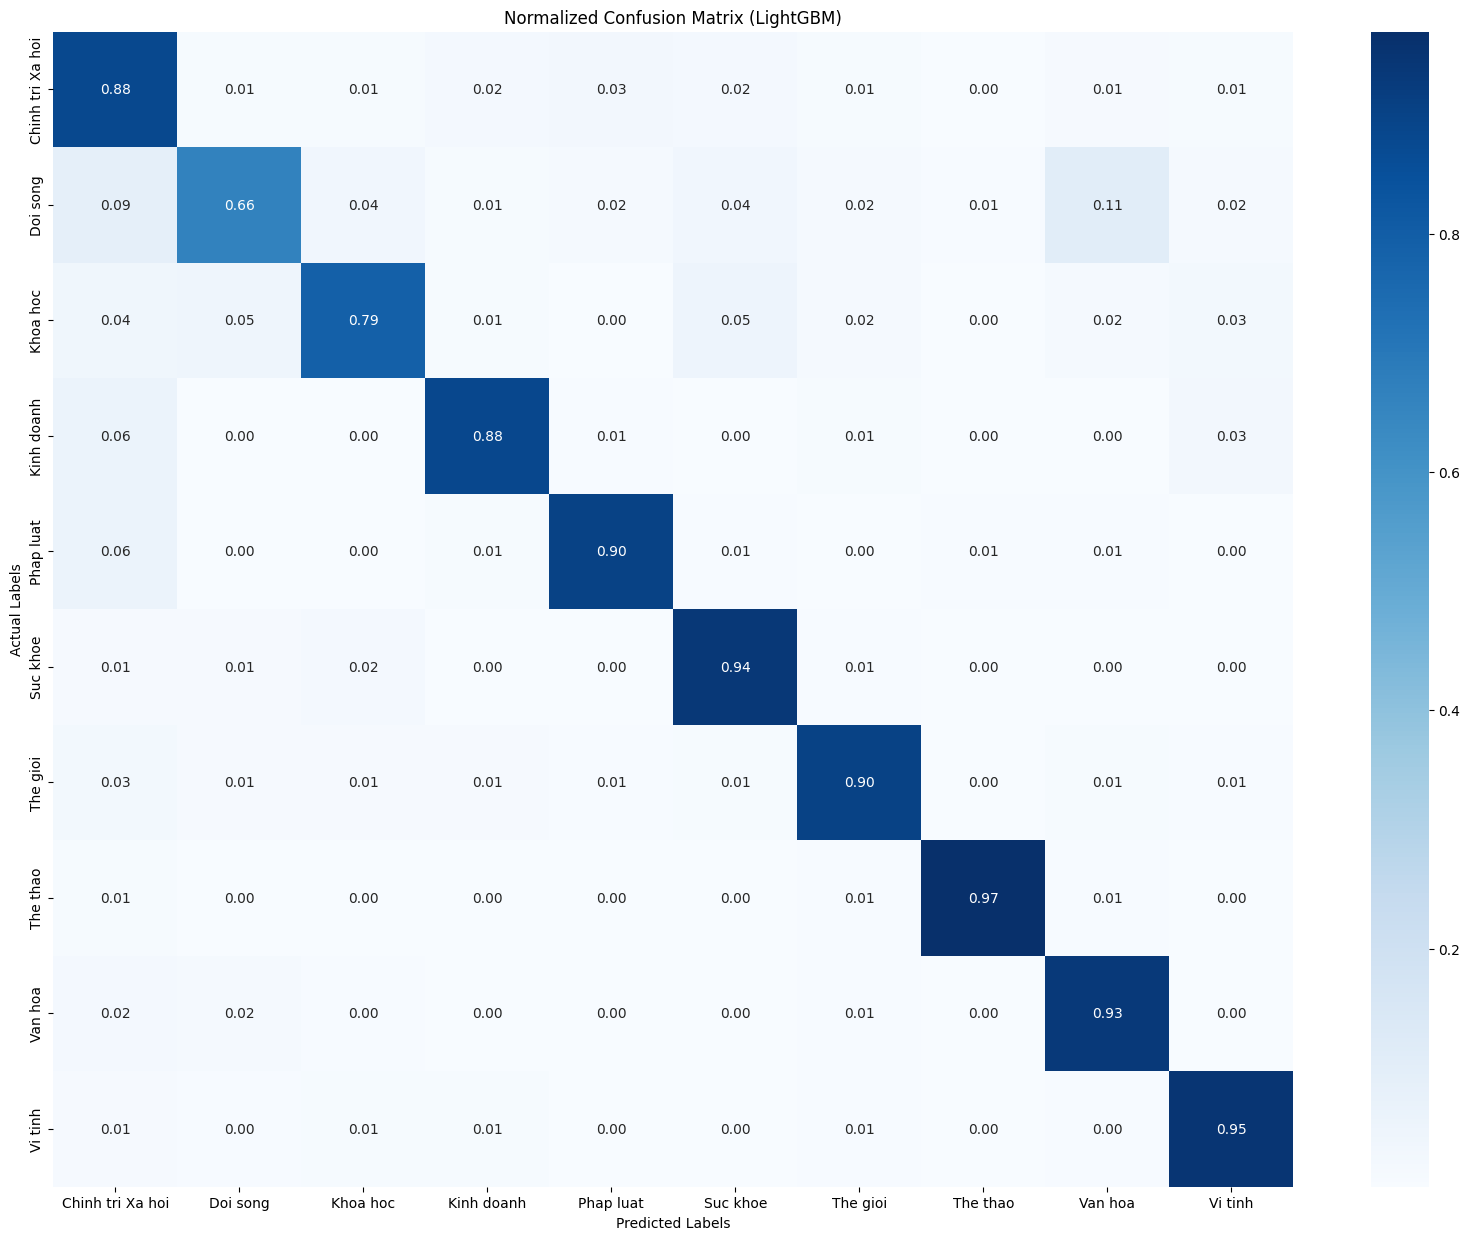

In [16]:
class_labels = le.inverse_transform(np.unique(y_test_enc))
cm = confusion_matrix(y_test_enc, y_pred, labels=np.unique(y_test_enc))

def normalize_confusion_matrix(cm, norm='true'):
    with np.errstate(divide='ignore', invalid='ignore'):
        if norm == 'true':
            cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        elif norm == 'pred':
            cm_normalized = cm.astype(float) / cm.sum(axis=0, keepdims=True)
        elif norm == 'all':
            cm_normalized = cm.astype(float) / cm.sum()
        else:
            raise ValueError("Unknown normalization type. Use 'true', 'pred', or 'all'.")
        cm_normalized = np.nan_to_num(cm_normalized)
    return cm_normalized

class_labels = le.inverse_transform(np.unique(y_test_enc))

plt.figure(figsize=(20, 15))
sns.heatmap(
    normalize_confusion_matrix(cm, norm='true'), 
    annot=True, fmt=".2f", cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Normalized Confusion Matrix (LightGBM)')
plt.show()
